In [1]:
!pip install geocoder
!pip install geopy
!pip install folium

import pandas as pd
import requests
import numpy as np
import geocoder
import folium 
import json 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import sklearn.utils

from bs4 import BeautifulSoup
from pandas.io.json import json_normalize 
from geopy.geocoders import Nominatim
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

     |████████████████████████████████| 102kB 7.0MB/s ta 0:00:011
     |████████████████████████████████| 102kB 7.8MB/s ta 0:00:011


In [2]:
# Get communes of Great Santiago
url = "https://es.wikipedia.org/wiki/Anexo:Comunas_de_Santiago_de_Chile"
extracting_data = requests.get(url).text
html_data = BeautifulSoup(extracting_data, 'lxml')

#html_data

In [3]:
col_names = ['Commune']
df = pd.DataFrame(columns = col_names)
    
content = html_data.find('table', class_='sortable')
table = content.tbody
comuna = 0

for tr in table.find_all('tr'):
    comuna = tr.find('a').text.strip('\n')

    df = df.append({'Commune': comuna}, ignore_index=True)
    
df = df.iloc[1:]
df.reset_index(drop = True, inplace = True)
df

,Commune
0,Cerrillos
1,Cerro Navia
2,Conchalí
3,El Bosque
4,Estación Central
5,Huechuraba
6,Independencia
7,La Cisterna
8,La Florida
9,La Granja


In [4]:
# Function to get coords of a commune
def get_coords(commune):
    lat_lon = None
    while(lat_lon is None):
        address = '{}, Chile'.format(commune)
        geolocator = Nominatim(user_agent="santiago_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        print( '{}, lat_lon: {}, {}'.format(commune, latitude, longitude) )
        lat_lon = [latitude, longitude]

    return lat_lon

In [5]:
# Get coords of all communes
coords = []

for commune in df['Commune']:    
    coords.append( get_coords(commune) )

len(coords)

Cerrillos, lat_lon: -33.5025026, -70.71591828411766
Cerro Navia, lat_lon: -33.42514465, -70.74395424193548
Conchalí, lat_lon: -33.384775149999996, -70.67460576456799
El Bosque, lat_lon: -33.56235185, -70.67681955928742
Estación Central, lat_lon: -33.463658249999995, -70.70496618631857
Huechuraba, lat_lon: -33.365721449999995, -70.6429271186091
Independencia, lat_lon: -33.416411749999995, -70.66581795393661
La Cisterna, lat_lon: -33.5295218, -70.66425289405431
La Florida, lat_lon: -33.530714450000005, -70.54402715938959
La Granja, lat_lon: -33.53587875, -70.62229522259899
La Pintana, lat_lon: -33.591388550000005, -70.63642326010053
La Reina, lat_lon: -33.44737295, -70.53341181233888
Las Condes, lat_lon: -33.4247879, -70.51749760753927
Lo Barnechea, lat_lon: -33.2935888, -70.39035501440654
Lo Espejo, lat_lon: -33.5201685, -70.6897368284454
Lo Prado, lat_lon: -33.44704385, -70.72339935540677
Macul, lat_lon: -33.49194265, -70.59973215756841
Maipú, lat_lon: -33.5094409, -70.756182
Ñuñoa, la

36

In [6]:
# Add coords to main dataframe
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

df

,Commune,Latitude,Longitude
0,Cerrillos,-33.502503,-70.715918
1,Cerro Navia,-33.425145,-70.743954
2,Conchalí,-33.384775,-70.674606
3,El Bosque,-33.562352,-70.676820
4,Estación Central,-33.463658,-70.704966
5,Huechuraba,-33.365721,-70.642927
6,Independencia,-33.416412,-70.665818
7,La Cisterna,-33.529522,-70.664253
8,La Florida,-33.530714,-70.544027
9,La Granja,-33.535879,-70.622295


In [2]:
# Foursquare connection
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'
LIMIT = 50

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [8]:
# Function to get Venues
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Commune', 
                  'Commune Latitude', 
                  'Commune Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
# Get venues of each commune. Radius is set to 10km to get all posible venues near the center of a commune
santiago_venues = getNearbyVenues(df['Commune'], df['Latitude'], df['Longitude'])

Cerrillos
Cerro Navia
Conchalí
El Bosque
Estación Central
Huechuraba
Independencia
La Cisterna
La Florida
La Granja
La Pintana
La Reina
Las Condes
Lo Barnechea
Lo Espejo
Lo Prado
Macul
Maipú
Ñuñoa
Padre Hurtado
Pedro Aguirre Cerda
Peñaflor
Peñalolén
Providencia
Pudahuel
Puente Alto
Quilicura
Quinta Normal
Recoleta
Renca
San Bernardo
San Joaquín
San Miguel
San Ramón
Santiago
Vitacura


In [10]:
print(santiago_venues.shape)
santiago_venues.head(20)

(1751, 7)


,Commune,Commune Latitude,Commune Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cerrillos,-33.502503,-70.715918,Fu Wen Sushi Bar,-33.512210,-70.719848,Sushi Restaurant
1,Cerrillos,-33.502503,-70.715918,"Viña Concha y Toro S.A., Lo Espejo",-33.523199,-70.729296,Vineyard
2,Cerrillos,-33.502503,-70.715918,Calfucura Buffet,-33.492065,-70.727675,South American Restaurant
3,Cerrillos,-33.502503,-70.715918,Coffee Culture,-33.507762,-70.759930,Coffee Shop
4,Cerrillos,-33.502503,-70.715918,Rústico,-33.500149,-70.752965,Brewery
5,Cerrillos,-33.502503,-70.715918,CrossFit 1810,-33.506736,-70.758017,Gym
6,Cerrillos,-33.502503,-70.715918,Il Piccolino,-33.509124,-70.752975,Pizza Place
7,Cerrillos,-33.502503,-70.715918,cuanto te quiero,-33.506382,-70.757164,Snack Place
8,Cerrillos,-33.502503,-70.715918,D'mechadas,-33.498226,-70.739265,Sandwich Place
9,Cerrillos,-33.502503,-70.715918,Picara Pajara,-33.510574,-70.660027,Pizza Place


In [11]:
venues = santiago_venues['Venue Category'].unique()
venues = pd.DataFrame(venues, columns = ['Category']).sort_values('Category')
venues.reset_index(drop = True, inplace = True)
venues

,Category
0,Airport
1,Airport Lounge
2,Airport Service
3,Airport Terminal
4,Amphitheater
5,Art Gallery
6,Arts & Crafts Store
7,Arts & Entertainment
8,Asian Restaurant
9,Athletics & Sports


In [12]:
# Get all parks, gardens or plazas and remove duplicates
parks = santiago_venues.loc[ (santiago_venues['Venue Category'] == 'Plaza') | 
                             (santiago_venues['Venue Category'] == 'Park') | 
                             (santiago_venues['Venue Category'] == 'Garden') ]

parks = parks.drop_duplicates(subset = ['Venue'])
parks = parks[['Venue', 'Venue Latitude', 'Venue Longitude']]
parks.reset_index(drop = True, inplace = True)
print(parks.shape)
parks.head()

(36, 3)


,Venue,Venue Latitude,Venue Longitude
0,Parque El Rosal,-33.485326,-70.765686
1,Running Fernández Albano,-33.523544,-70.660307
2,Viveros de Renca,-33.403115,-70.734140
3,Parque Forestal,-33.436429,-70.640126
4,Parque Bicentenario,-33.400747,-70.601693


In [13]:
# Get coordinates of Santiago
address = 'Santiago, Chile'
geolocator = Nominatim(user_agent="santiago_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of Santiago, Chile are {}, {}.'.format(latitude, longitude))

The coordinates of Santiago, Chile are -33.4377968, -70.6504451.


In [14]:
# Visualize parks
map_santiago = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(parks['Venue Latitude'], parks['Venue Longitude'], parks['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='green', fill=True, fill_color='#36cc33', fill_opacity=0.7,parse_html=False).add_to(map_santiago)  
map_santiago

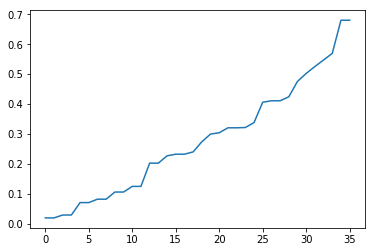

In [15]:
# DBSCAN
cluster_dataSet = parks[['Venue Latitude','Venue Longitude']]
cluster_dataSet = StandardScaler().fit_transform(cluster_dataSet)

# Calculate optimal eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(cluster_dataSet)
distances, indices = nbrs.kneighbors(cluster_dataSet)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [16]:
# Compute DBSCAN
db = DBSCAN(eps=0.4, min_samples=2).fit(cluster_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
parks["Cluster"] = labels

clusterNum = len(set(labels))

print( 'There are {} clusters'.format(clusterNum - 1) )
parks.head()

There are 6 clusters


,Venue,Venue Latitude,Venue Longitude,Cluster
0,Parque El Rosal,-33.485326,-70.765686,-1
1,Running Fernández Albano,-33.523544,-70.660307,-1
2,Viveros de Renca,-33.403115,-70.734140,-1
3,Parque Forestal,-33.436429,-70.640126,0
4,Parque Bicentenario,-33.400747,-70.601693,0


In [27]:
# Visualize parks
map_santiago = folium.Map(location=[latitude, longitude], zoom_start=11)

# Colormap
colors_array = cm.gist_ncar(np.linspace(0, 1, clusterNum))
color_map = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, label, cluster in zip(parks['Venue Latitude'], parks['Venue Longitude'], parks['Venue'], parks['Cluster']):
    popup = label
    c = 'red'
    if cluster != -1:
        c = color_map[cluster]
        popup = label + '<br>' + 'Cluster ' + str(cluster + 1)
                       
    label = folium.Popup(popup)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color=c, fill=True, fill_color=c, fill_opacity=0.7,parse_html=False).add_to(map_santiago) 
    
map_santiago